In [1]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# @title
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D ,Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Accuracy, MeanAbsoluteError
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau

In [3]:
# @title
def get_gender_model(input_shape):
    inpt = Input(input_shape)
    conv = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    conv = conv(inpt)
    flt = GlobalAveragePooling2D()(conv)
    dense1 = Dense(256,activation = "relu")(flt)
    dense1 = Dropout(0.3)(dense1)
    dense2 = Dense(128,activation = "relu")(dense1)
    dense2 = Dropout(0.3)(dense2)
    dense3 = Dense(64,activation = "relu")(dense2)
    dense3 = Dropout(0.3)(dense3)
    dense4 = Dense(32,activation = "relu")(dense3)
    dense4 = Dropout(0.3)(dense4)
    gender = Dense(1, activation = "sigmoid", name = "gender_output")(dense4)
    model = Model(inputs = inpt, outputs = gender)

# base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
    return model

def get_age_model(input_shape):
    inpt = Input(input_shape)
    conv = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    conv = conv(inpt)
    flt = GlobalAveragePooling2D()(conv)
    dense1 = Dense(512,activation = "relu")(flt)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(256,activation = "relu")(dense1)
    dense2 = Dropout(0.2)(dense2)
    dense3 = Dense(128,activation = "relu")(dense2)
    dense3 = Dropout(0.2)(dense3)
    age = Dense(1, activation = "linear",name = "age_output")(dense3)
    model = Model(inputs = inpt, outputs = age)

# base_learning_rate = 0.0001
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),metrics=['mean_absolute_error'])
    return model

In [4]:
# @title
gender_model = get_gender_model((128,128,3))
age_model = get_age_model((128,128,3))

9406464/9406464 [==============================] - 1s 0us/step


In [5]:
# @title
gender_model.load_weights('/content/topgender_weights.keras')
age_model.load_weights('/content/topage_weights.keras')

The Following code Extract Faces from images and resizes the images to 128,128,3

In [6]:
def reshape_images_cv2(image_list):
  reshaped_images = []
  for image in image_list:
    # Check if the image is already the desired size
    if image.shape == (128, 128, 3):
      reshaped_images.append(image)
    else:
      # Reshape the image to 128x128x3
      reshaped_image = cv2.resize(image, (128, 128))
      reshaped_images.append(reshaped_image)

  return reshaped_images

In [7]:
def read_image(image_path):
  img = cv2.imread(image_path)
  if img is None:
    print("Error: Unable to load image.")
    return None
  else:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  return img

In [8]:
def extract_frontal_faces(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Load the pre-trained face cascade classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return None, None

    # Extract faces and their coordinates
    extracted_faces = []
    face_coordinates = []
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        extracted_faces.append(face)
        face_coordinates.append((x, y, x+w, y+h))  # (x1, y1, x2, y2) coordinates of face
    extracted_faces = reshape_images_cv2(extracted_faces)
    extracted_faces = np.stack(extracted_faces)/255.

    return extracted_faces, face_coordinates

In [9]:
def get_prediction(faces,gender_m, age_m):
  gender = gender_m.predict(faces,verbose = 0)
  age = age_m.predict(faces,verbose = 0)
  age = (np.round(age)).astype(int)
  age = [str(integer[0]) for integer in age]
  gender = (gender>0.5).astype(int)
  gender = ["Male" if g == 0 else "Female" for g in gender]
  predictions = [[pair[0],pair[1]] for pair in zip(gender, age)]
  return predictions

In [40]:
def draw_bounding_boxes(image, bounding_boxes,texts):
  for i,bounding_box in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bounding_box
    text1, text2 = texts[i]
    # Draw the bounding box on the image
    x, y = image.shape[0], image.shape[1]
    thickness = min(3,max(1,int(abs(x) / 200)))
    font_scale = min(2,max(1,int(abs(y) / 400)))
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text1, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
    cv2.putText(image, text2, (x2, y2 + 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

  return image

In [41]:
def predict(img, gender_mo,age_mo):
  faces, coordinates = extract_frontal_faces(img)
  if coordinates is not None:
    predictions = get_prediction(faces, gender_mo,age_mo)
    img = draw_bounding_boxes(img,coordinates,predictions)
    return img,predictions
  else:
    print("No Faces Found")
    return None

['Male', '31']


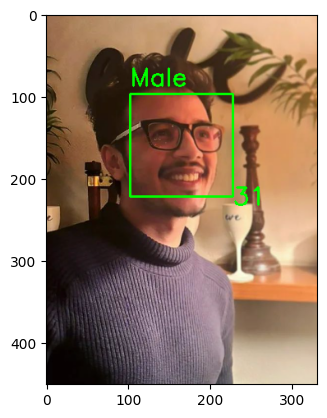

In [42]:
image_path = '/content/sample.jpeg'
img = read_image(image_path)
image, preds = predict(img,gender_model,age_model)
plt.imshow(image)
for i in preds:
  print(i)

['Male', '30']


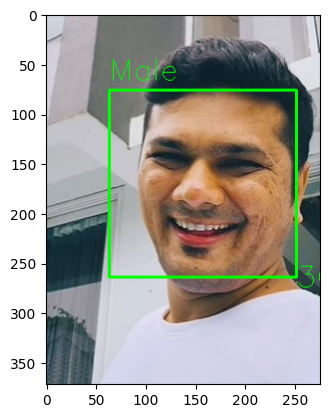

In [43]:
image_path = '/content/sample2.jpeg'
img = read_image(image_path)
image, preds = predict(img,gender_model,age_model)
plt.imshow(image)
for i in preds:
  print(i)

['Female', '27']
['Female', '3']
['Male', '34']


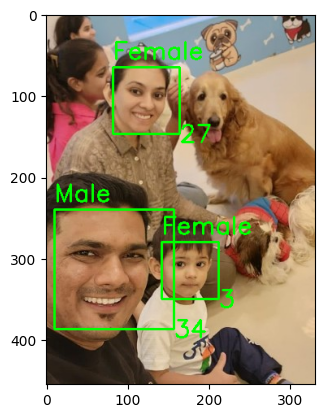

In [44]:
image_path = '/content/sample3.jpeg'
img = read_image(image_path)
image, preds = predict(img,gender_model,age_model)
plt.imshow(image)
for i in preds:
  print(i)

['Male', '18']
['Female', '25']
['Female', '2']


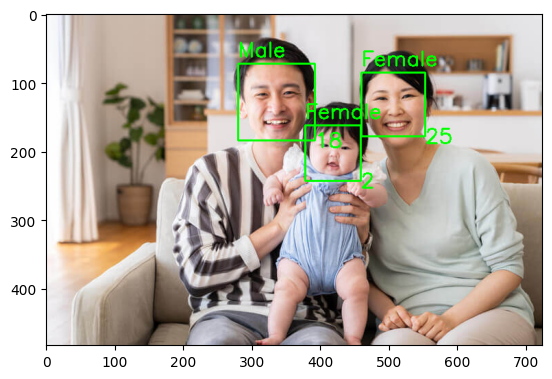

In [45]:
image_path = '/content/family.jpg'
img = read_image(image_path)
image, preds = predict(img,gender_model,age_model)
plt.imshow(image)
for i in preds:
  print(i)

['Male', '27']
['Male', '30']
['Male', '32']
['Male', '26']
['Male', '32']


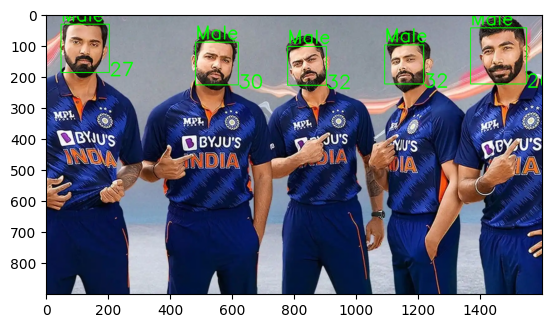

In [46]:
image_path = '/content/ict.webp'
img = read_image(image_path)
image, preds = predict(img,gender_model,age_model)
plt.imshow(image)
for i in preds:
  print(i)

In [51]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [57]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [58]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [59]:
## Note not important
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [79]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    extracted_faces = []
    face_coordinates = []
    # get face bounding box for overlay
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        extracted_faces.append(face)
        face_coordinates.append((x, y, x+w, y+h))  # (x1, y1, x2, y2) coordinates of face

    if len(face_coordinates) != 0:
      extracted_faces = reshape_images_cv2(extracted_faces)
      extracted_faces = np.stack(extracted_faces)/255.
      predictions = get_prediction(extracted_faces, gender_model,age_model)
      for i,(x1,y1,x2,y2) in enumerate(face_coordinates):
        bbox_array = cv2.rectangle(bbox_array,(x1,y1),(x2,y2),(255,0,0),2)
        [text1,text2] = predictions[i]
        cv2.putText(bbox_array, text1, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
        cv2.putText(bbox_array, text2, (x2, y2 + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>